In [1]:
 import pandas as pd
import seaborn as sns
import numpy as np
import csv
import plotly.offline as pyo
import plotly.graph_objs as go
import plotly.express as px
import plotly.io as pio
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, metrics, optimizers, utils, initializers
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras import layers, models, metrics, optimizers, utils
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot
from tensorflow.keras.models import load_model
from IPython.display import Image

from sklearn.model_selection import train_test_split

# Fingerprinting - 3 classes -3 Servers

In this notebook, we are doing fingerprinting on BLE packets, meaning that we are trying to identify an emitter based on the traffic it emits. We are using data from Scenario 5, in which the emitter and the server are still, using 3 nRF52 dev kits used as BLE advertising devices, 4 USRPs used as receivers. We are using raw IQ data as input. 
We are using data solely from Scene 35, Scene 36 and Scene 37 in which only one emitter is advertising. In Scene 36 it is a nRF52 apuP22, and in Scene 37 it is nRF52 apuQ2. This means that we now have 3 classes. We are using data from all servers. All the models used are the final version of each model tested in notebook "fingerprinting_ble_3_classes_1_server".

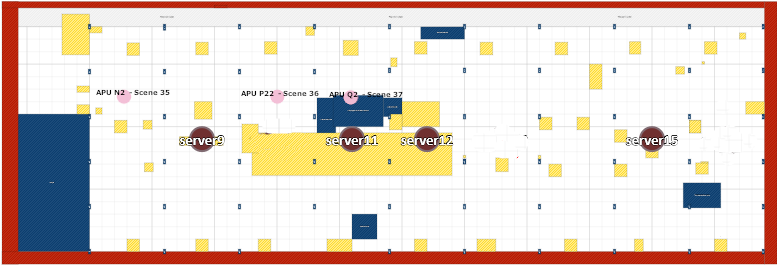

In [2]:
Image("../img/3server_353637.PNG")

## Performances summary

| NN type | Parameters | Accuracy |
| --- | --- | --- |
| Simple CNN | 1Conv2d: 52 | 0.36|

In [3]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [4]:
files=('../data/processed/scenario5_scene35.csv','../data/processed/scenario5_scene36.csv','../data/processed/scenario5_scene37.csv')

idata = pd.concat([pd.read_csv(f) for f in files])


In [5]:
print(idata['Server_id'].value_counts())

print(idata['Len Packet'].value_counts())

11    1770600
9     1760720
15    1515080
12    1387200
Name: Server_id, dtype: int64
1520    5976640
1880     246280
1360     161840
880       28160
1320      17160
1760       3520
Name: Len Packet, dtype: int64


In [6]:
#selecting data  with pkt len=1520

idata=idata[idata['Len Packet']==1520]
print(len(idata.index))

5976640


## Creating Neural Network input

We are creating input for the CNN: X is composed of 1520 IQ samples, and Y is the scene number, meaning the emitter used in each of these scenes. The input data, i.e. the IQ data are normalized.

In [7]:

scaler = MinMaxScaler(feature_range=(0, 1))
idata[['real','im']]=scaler.fit_transform(idata[['real','im']].values)

### Use the whole packet as input

In [8]:
def input_whole_pkt(idata):
    #creating input for CNN: IQ values for a whole pkt     output: scene = robot_node
    X=list()
    Y=list()

    pkt_len=1520

    i=0
    while i<len(idata.index):
        data=idata.iloc[i:i+pkt_len]
        server=idata['Server_id'].iloc[i]
        if len(data['Time'].unique())==1:
            data_np=np.array(data[['real','im']], dtype='float64')
            x=data_np.reshape(pkt_len,2)
            X.append(x)
            Y.append(int(idata.iloc[i]['Scene']))  #in each scene a different emitter is used ~ robot_node in that case
        else:
            print('Missing!!')
        i=i+pkt_len

    X=np.array(X)
    Y=np.array(Y, dtype=int)

    input_shape=(pkt_len,2)
    batch_size=10
    
    print("Il y a "+str(len(Y))+" échantillons")
    
    return (X, Y, input_shape, batch_size)

### Use only part of the packet as input

In [9]:
def input_part_pkt(idata):
    #creating input for CNN: IQ values for a whole pkt     output: robot_node
    X=list()
    Y=list()
    pkt_len=1520
    i=0
    while i<len(idata.index):
        data=idata.iloc[i+744:i+944]
        server=idata['Server_id'].iloc[i]
        if len(data['Time'].unique())==1:
            data_np=np.array(data[['real','im']], dtype='float64')
            x=data_np.reshape(200,2)
            X.append(x)
            Y.append(int(idata.iloc[i]['Scene']))  #in each scene a different emitter is used ~ robot_node in that case
        else:
            print('Missing!!')
        i=i+pkt_len

    X=np.array(X)
    Y=np.array(Y, dtype=int)
    
    batch_size=10
    input_shape=(200,2)
    
    print("Il y a "+str(len(Y))+" échantillons")
    
    return (X, Y, input_shape, batch_size)

### Creates overlapping slices of each packet and gather them into a batch

In [10]:
def input_slices_pkt(idata, len_slice, shift):
    #creating input for CNN: IQ values for a whole pkt     output: robot_node
    X=list()
    Y=list()
    pkt_len=1520
    i=0
    while i<len(idata.index):
        data=idata.iloc[i:i+pkt_len]
        server=idata['Server_id'].iloc[i]
        if len(data['Time'].unique())==1:
            data=np.array(data[['real','im']], dtype='float64')
            x=data.reshape((pkt_len),2)
            #creates slices of the packet and gather them in a single batch
            x=tf.data.Dataset.from_tensor_slices(x)
            x = x.window(len_slice, shift, 1, True)
            count=0
            for window in x:
                w=list(window.as_numpy_iterator())
                w=np.array(w)
                X.append(w)
                count=count+1

                Y.append(int(idata.iloc[i]['Scene']))  #in each scene a different emitter is used ~ robot_node in that case
        else:
            print('Missing!!')
        i=i+pkt_len

    X=np.array(X)
    Y=np.array(Y, dtype=int)

    input_shape=X[0].shape
    batch_size=count
    
    print("Il y a "+str(len(Y))+" échantillons")
    
    return (X, Y, input_shape, batch_size)

## Balancing classes

We are manually balancing the classes to make classification easier and avoid bias due to class imbalance.

In [11]:
def balance_classes(X,Y):
    unique_elements, counts_elements = np.unique(Y, return_counts=True)


    #balance classes
    min_samples=min(counts_elements)


    thirty_five_index=np.where(Y == 35)
    thirty_five_index=thirty_five_index[0][:min_samples]
    X_thirty_five=X[thirty_five_index]
    Y_thirty_five=Y[thirty_five_index]

    thirty_six_index=np.where(Y == 36)
    thirty_six_index=thirty_six_index[0][:min_samples]
    X_thirty_six=X[thirty_six_index]
    Y_thirty_six=Y[thirty_six_index]

    thirty_seven_index=np.where(Y == 37)
    thirty_seven_index=thirty_seven_index[0][:min_samples]
    X_thirty_seven=X[thirty_seven_index]
    Y_thirty_seven=Y[thirty_seven_index]

    X=np.concatenate((X_thirty_five, X_thirty_six, X_thirty_seven))
    Y=np.concatenate((Y_thirty_five, Y_thirty_six, Y_thirty_seven))

    print(np.unique(Y, return_counts=True))
    return (X,Y)

We are attributing a class number (0,1,2) to each scene: 35 is 0, 36 is 1 and 37 is 2.

In [12]:
def name_classes(Y):
    Y_change=list()

    #35:0, 36:1 37:2
    for i in Y:
        if i==35:
            Y_change.append(0)
        elif i==36:
            Y_change.append(1)
        elif i==37:
            Y_change.append(2)

    Y_change=np.array(Y_change)
    
    return Y_change

In [13]:
def data_preparation_nn(idata, type_input, len_slice, shift):
    if type_input=='whole':
        X,Y,input_shape,batch_size=input_whole_pkt(idata)
    elif type_input=='part':
        X,Y,input_shape,batch_size=input_part_pkt(idata)
    elif type_input=='slice':
        X,Y,input_shape,batch_size=input_slices_pkt(idata, len_slice, shift)
   
    X,Y=balance_classes(X,Y)
    Y_change=name_classes(Y)
    
    unique_elements, counts_elements = np.unique(Y_change, return_counts=True)
    nb_class=max(unique_elements)+1
        
    Y_cat=utils.to_categorical(Y_change, num_classes=nb_class)

    X_train, X_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.2, random_state=54)
    return(X_train, X_test, y_train, y_test, input_shape, batch_size)

In [14]:
def plot_accuracy(history):
    i = np.arange(len(history.history['loss']))
    plt.xlabel('Step')
    plt.ylabel('Accuracy')
    plt.plot(i, history.history['accuracy'], label='accuracy')
    plt.plot(i, history.history['val_accuracy'], label='val_accuaracy')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

In [15]:
def test_metrics(model, y_test, X_test):
    predictions= model.predict(X_test)
    predictions = [np.argmax(y, axis=0, out=None) for y in predictions]
    y_test_cat = [np.argmax(y, axis=0, out=None) for y in y_test]
    
    present_class_list=np.unique(y_test_cat)

    # Confusion Matrix
    conf_mat=confusion_matrix(y_test_cat, predictions, labels=present_class_list)

    #F1-score
    print("f1_score for each class")
    f1_each=f1_score(y_test_cat, predictions, average=None, labels=present_class_list)
    print(f1_each)

    #F1-score
    print("Global f1_score")
    print(f1_score(y_test_cat, predictions, average='weighted'))

    #accyracy
    print("Global accuracy")
    print(accuracy_score(y_test_cat,predictions))

    import seaborn as sns
    cmap = sns.diverging_palette(200, 10, as_cmap=True)
    sns.heatmap(conf_mat, cmap=cmap, xticklabels=present_class_list, yticklabels=present_class_list)

## CNN 1 / AlexNet 1D

We are now trying a feedforward CNN, inspired by the one in the following article: "More is better: Data Augmentation for channel-Resilient RF Fingerprinting" by Nasim Soltani. It is also described in "RF Fingerprinting Unnanned Aerial Vehicles with Non-Standard Transmitter Waveforms", in which it is called AlexNet1D.

200 shift 150: 0.53
200 shift 50:0.37
part:0.35
500 shift 250: 0.33

| Experiments | Val-accuracy | Comments |
| --- | --- | --- |
| Normal input slice: 200 shift 150) | 0.61 | |
| --- | --- | --- |
| Add server_id in input (slice: 200 shift 150) | 0.53 | Overfits|
| --- | --- | --- |
| Add server_id in input (slice: 200 shift 50) | 0.37 | Overfits|
| --- | --- | --- |
| Add server_id in input (part) | 0.35 | Overfits|
| --- | --- | --- |
| Add server_id in input (slice: 500 shift 250) | 0.33 | Overfits|
| --- | --- | --- |
| Normal input (slice: 500 shift 250) | 0.83 | Overfits a little|

In [16]:
X_train, X_test, y_train, y_test, input_shape, nb_slice=data_preparation_nn(idata, 'slice', 450, 30)

steps=300
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10)

model = models.Sequential()
model.add(layers.BatchNormalization(input_shape=input_shape))
model.add(layers.GaussianNoise(0.1,input_shape=input_shape))

for i in range(3):
    model.add(layers.Conv1D(filters=140, kernel_size=(6), padding='valid',activation='tanh'))
    model.add(layers.Conv1D(filters=300, kernel_size=(6), padding='valid',activation='tanh'))
    model.add(layers.MaxPooling1D((2)))

model.add(layers.Dense(units=650))
model.add(layers.Dense(units=400))

model.add(layers.Flatten())
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer=optimizers.Adam(learning_rate = 0.0001),
          loss=tf.keras.losses.categorical_crossentropy,
          metrics=['accuracy'])

history=model.fit(X_train, y_train, batch_size=60, epochs=steps, verbose=1, validation_split=0.2,
                 callbacks=[callback])


KeyboardInterrupt: 

In [ ]:
plot_accuracy(history)
test_metrics(model, y_test, X_test)

## CNN 2

| Experiments | Test Accuracy | Comments |
| --- | --- | --- |
| Normal input (slice: 500 shift 250) | 0.81 | Overfits a little|



We are now trying a more complex CNN, also described in the same article.

In [19]:
#X_train, X_test, y_train, y_test, input_shape, batch_size=data_preparation_nn(idata, 'slice')

steps=300

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=100)

model = models.Sequential()
model.add(layers.BatchNormalization(input_shape=input_shape))
model.add(layers.GaussianNoise(0.1))
for i in range(3):
    model.add(layers.Conv1D(filters=60, kernel_size=(2), padding='valid',activation='relu'))
    model.add(layers.MaxPooling1D((2)))
    model.add(layers.Dense(units=300))


model.add(layers.Dense(units=750))

model.add(layers.Flatten())          
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer=optimizers.Adam(learning_rate = 0.0001),
          loss=tf.keras.losses.categorical_crossentropy,
          metrics=['accuracy'])

history=model.fit(X_train, y_train, batch_size=batch_size, epochs=steps, verbose=1, validation_split=0.2,
                 callbacks=[callback])


Epoch 1/300
339/339 [==============================] - 16s 47ms/step - loss: 1.0720 - accuracy: 0.3743 - val_loss: 1.0996 - val_accuracy: 0.3593
Epoch 2/300
339/339 [==============================] - 2s 7ms/step - loss: 1.0541 - accuracy: 0.4281 - val_loss: 1.0860 - val_accuracy: 0.4350
Epoch 3/300
339/339 [==============================] - 2s 7ms/step - loss: 1.0237 - accuracy: 0.4441 - val_loss: 1.0404 - val_accuracy: 0.4374
Epoch 4/300
339/339 [==============================] - 2s 7ms/step - loss: 0.9481 - accuracy: 0.4885 - val_loss: 1.4490 - val_accuracy: 0.4634
Epoch 5/300
339/339 [==============================] - 2s 7ms/step - loss: 0.8750 - accuracy: 0.5517 - val_loss: 2.0070 - val_accuracy: 0.4634
Epoch 6/300
339/339 [==============================] - 2s 7ms/step - loss: 0.8272 - accuracy: 0.5766 - val_loss: 2.4815 - val_accuracy: 0.4184
Epoch 7/300
339/339 [==============================] - 2s 7ms/step - loss: 0.7938 - accuracy: 0.6002 - val_loss: 2.5165 - val_accuracy: 0.47

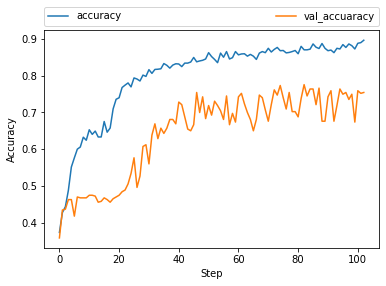

f1_score for each class
[0.98016997 0.74175824 0.72140762]
Global f1_score
0.8149124384485243
Global accuracy
0.8147448015122873


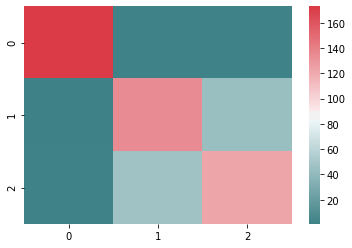

In [20]:
plot_accuracy(history)
test_metrics(model, y_test, X_test)

## Conv RNN

Let's now try out the third model described in the article, which is a Convolutional Recurrent Network.

| CNN 1 type | Test Accuracy | Comments |
| --- | --- | --- |
| Normal input (slices: 500 shift 250)|0.68|Overfits + one class is not well recognized|


In [21]:
#X_train, X_test, y_train, y_test, input_shape, batch_size=data_preparation_nn(idata, 'slice')

steps=300
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=100)


model = models.Sequential()
model.add(layers.BatchNormalization(input_shape=input_shape))
model.add(layers.GaussianNoise(0.1))
for i in range(2):
    model.add(layers.Conv1D(filters=430, kernel_size=(6), padding='valid',activation='tanh'))
    model.add(layers.MaxPooling1D((2)))


model.add(layers.SimpleRNN(units=400,activation="relu"))

model.add(layers.Dense(units=250))
model.add(layers.Dense(units=350))

model.add(layers.Flatten())          
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer=optimizers.Adam(learning_rate = 0.0001),
          loss=tf.keras.losses.categorical_crossentropy,
          metrics=['accuracy'])

history=model.fit(X_train, y_train, batch_size=batch_size, epochs=steps, verbose=1, validation_split=0.2,
                 callbacks=[callback])


Epoch 1/300
339/339 [==============================] - 36s 107ms/step - loss: 1.0806 - accuracy: 0.3672 - val_loss: 1.0964 - val_accuracy: 0.3688
Epoch 2/300
339/339 [==============================] - 24s 71ms/step - loss: 1.0517 - accuracy: 0.4329 - val_loss: 1.0840 - val_accuracy: 0.4704
Epoch 3/300
339/339 [==============================] - 24s 72ms/step - loss: 0.8504 - accuracy: 0.5713 - val_loss: 0.7208 - val_accuracy: 0.6265
Epoch 4/300
339/339 [==============================] - 24s 72ms/step - loss: 0.7215 - accuracy: 0.6274 - val_loss: 0.7533 - val_accuracy: 0.6265
Epoch 5/300
339/339 [==============================] - 25s 72ms/step - loss: 0.6704 - accuracy: 0.6700 - val_loss: 0.7254 - val_accuracy: 0.7116
Epoch 6/300
339/339 [==============================] - 24s 72ms/step - loss: 0.5975 - accuracy: 0.6925 - val_loss: 0.7622 - val_accuracy: 0.6619
Epoch 7/300
339/339 [==============================] - 24s 71ms/step - loss: 0.6528 - accuracy: 0.6677 - val_loss: 0.9517 - val_a

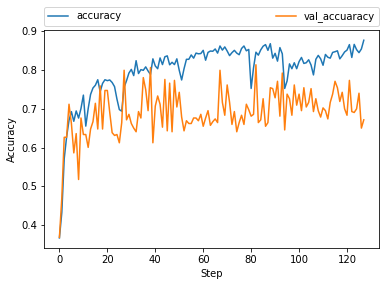

f1_score for each class
[0.96045198 0.65384615 0.31355932]
Global f1_score
0.645793026620299
Global accuracy
0.6805293005671077


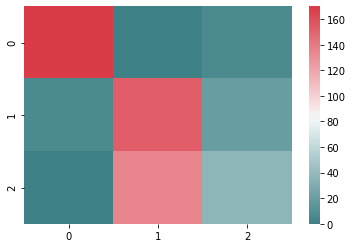

In [22]:
plot_accuracy(history)
test_metrics(model, y_test, X_test)

## ResNet 1D

| CNN 1 type | Test Accuracy | Comments |
| --- | --- | --- |
| Normal input (slices: 500 shift 250)| 0.83 | Overfits a little|



In [24]:
def proj_block(x: tf.Tensor, filters):
    y_first = layers.Conv1D(kernel_size=1,
               filters=filters,
               padding="same", activation='relu')(x)
    y_first = layers.Conv1D(kernel_size=3,
               filters=filters,
               activation='relu')(y_first)
    y_first = layers.Conv1D(kernel_size=1,
               filters=4*filters,
               activation='relu')(y_first)
    
    y_second = layers.Conv1D(kernel_size=1,
               filters=4*filters,
               padding="same", activation='relu')(x)
    
    y = layers.concatenate([y_first,  y_second], axis=1)
    y = layers.Activation(activation='relu')(y)

    return y

In [25]:
def id_block(x: tf.Tensor, filters):
    y_first = layers.Conv1D(kernel_size=1,
               filters=filters,
               padding="same", activation='relu')(x)
    y_first = layers.Conv1D(kernel_size=3,
               filters=filters,
               activation='relu')(y_first)
    y_first = layers.Conv1D(kernel_size=1,
               filters=4*filters,
               activation='relu')(y_first)
    
    y = layers.concatenate([y_first,  x], axis=1)
    y = layers.Activation(activation='relu')(y)

    return y

In [23]:
X_train, X_test, y_train, y_test, input_shape, batch_size=data_preparation_nn(idata, 'slice')

Il y a 3932 échantillons
(array([35, 36, 37]), array([881, 881, 881]))


In [26]:

steps=300
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=100)

inputs = layers.Input(shape=input_shape)

t=layers.BatchNormalization()(inputs)
t=layers.GaussianNoise(0.1)(t)
t=layers.Conv1D(kernel_size=7,
               filters=64,
               activation='relu')(t)
t=layers.MaxPool1D(2)(t)
t=proj_block(t,64)
for i in range(2):
    t=id_block(t,64)

t=proj_block(t,128)
for j in range(3):
    t=id_block(t,128)
#t=proj_block(t,256)
#for k in range(1):
#    t=id_block(t,256)
#t=proj_block(t,512)  
#for l in range(2):
#    t=id_block(t,512)
t=layers.AveragePooling1D(2)(t)
t=layers.Flatten()(t)
outputs=layers.Dense(3,activation='softmax')(t)

model = tf.keras.models.Model(inputs, outputs)

model.compile(optimizer=optimizers.Adam(learning_rate = 0.0001),
          loss=tf.keras.losses.categorical_crossentropy,
          metrics=['accuracy'])

history=model.fit(X_train, y_train, batch_size=batch_size, epochs=steps, verbose=1, validation_split=0.2,
                 callbacks=[callback])


Epoch 1/300
339/339 [==============================] - 162s 478ms/step - loss: 1.0744 - accuracy: 0.3672 - val_loss: 1.0992 - val_accuracy: 0.3522
Epoch 2/300
339/339 [==============================] - 19s 56ms/step - loss: 1.0344 - accuracy: 0.4287 - val_loss: 1.0590 - val_accuracy: 0.3853
Epoch 3/300
339/339 [==============================] - 19s 56ms/step - loss: 0.9434 - accuracy: 0.5127 - val_loss: 1.3820 - val_accuracy: 0.4374
Epoch 4/300
339/339 [==============================] - 19s 56ms/step - loss: 0.8159 - accuracy: 0.5837 - val_loss: 1.8517 - val_accuracy: 0.4421
Epoch 5/300
339/339 [==============================] - 19s 56ms/step - loss: 0.7382 - accuracy: 0.6198 - val_loss: 1.5544 - val_accuracy: 0.4752
Epoch 6/300
339/339 [==============================] - 19s 56ms/step - loss: 0.5611 - accuracy: 0.7274 - val_loss: 1.3024 - val_accuracy: 0.4775
Epoch 7/300
339/339 [==============================] - 19s 56ms/step - loss: 0.4353 - accuracy: 0.7753 - val_loss: 1.0675 - val_

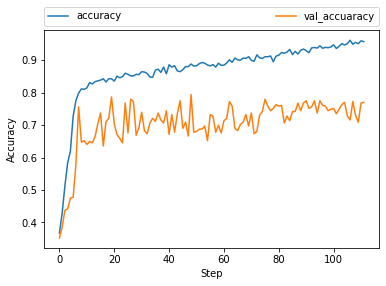

f1_score for each class
[0.98863636 0.74635569 0.76584022]
Global f1_score
0.8337564793829633
Global accuracy
0.833648393194707


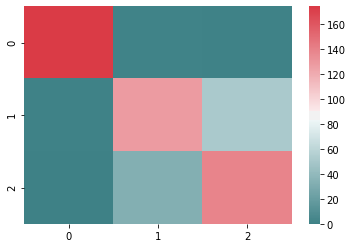

In [27]:
plot_accuracy(history)
test_metrics(model, y_test, X_test)

## CNN Conv2D

| Experiments | Test Accuracy | Comments |
| --- | --- | --- |
| Normal input (slices: 500 shift 250)| 0.68 | f1 score for some classes is extremely low|



In [42]:
X_train, X_test, y_train, y_test, input_shape, batch_size=data_preparation_nn(idata, 'slice')

X_train=X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2],1))
X_test=X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2],1))

input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])

steps=300
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=100)

model = models.Sequential()
model.add(layers.BatchNormalization(input_shape=input_shape))
model.add(layers.GaussianNoise(0.1))

model.add(layers.Conv2D(filters=110, kernel_size=(5,1), padding='valid',activation='tanh'))
model.add(layers.MaxPooling2D((2,1)))
model.add(layers.Conv2D(filters=150, kernel_size=(6,1), padding='valid',activation='relu'))
model.add(layers.MaxPooling2D((2,1)))
model.add(layers.Conv2D(filters=40, kernel_size=(9,2), padding='valid',activation='relu'))
model.add(layers.MaxPooling2D((2,1)))

model.add(layers.Dense(units=280, activation='relu'))
model.add(layers.Dense(units=480, activation='tanh'))

model.add(layers.Flatten())          
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer=optimizers.Adam(learning_rate = 0.0001),
          loss=tf.keras.losses.categorical_crossentropy,
          metrics=['accuracy'])

history=model.fit(X_train, y_train, batch_size=batch_size, epochs=steps, verbose=1, validation_split=0.2,
                 callbacks=[callback])


Il y a 3932 échantillons
(array([35, 36, 37]), array([881, 881, 881]))
Epoch 1/300
339/339 [==============================] - 22s 65ms/step - loss: 1.0701 - accuracy: 0.3643 - val_loss: 1.0976 - val_accuracy: 0.3617
Epoch 2/300
339/339 [==============================] - 2s 6ms/step - loss: 1.0454 - accuracy: 0.4240 - val_loss: 1.0313 - val_accuracy: 0.4492
Epoch 3/300
339/339 [==============================] - 2s 6ms/step - loss: 0.9513 - accuracy: 0.5115 - val_loss: 1.7233 - val_accuracy: 0.4539
Epoch 4/300
339/339 [==============================] - 2s 6ms/step - loss: 0.8354 - accuracy: 0.5914 - val_loss: 2.3961 - val_accuracy: 0.4775
Epoch 5/300
339/339 [==============================] - 2s 6ms/step - loss: 0.7567 - accuracy: 0.6304 - val_loss: 3.3215 - val_accuracy: 0.4704
Epoch 6/300
339/339 [==============================] - 2s 6ms/step - loss: 0.7407 - accuracy: 0.6268 - val_loss: 3.4654 - val_accuracy: 0.4894
Epoch 7/300
339/339 [==============================] - 2s 6ms/step - 

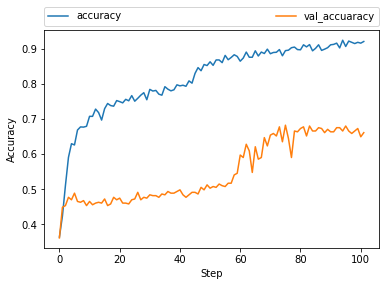

f1_score for each class
[0.98295455 0.66247379 0.29694323]
Global f1_score
0.6508553371874909
Global accuracy
0.6899810964083176


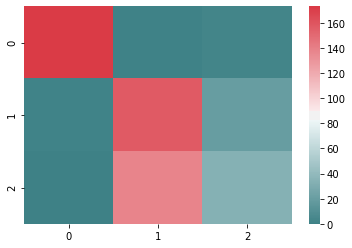

In [44]:
plot_accuracy(history)
test_metrics(model, y_test, X_test)

## CNN1 + Autoencoder

We will now use the best out of our tuned Networks (CNN1) and try to apply an autoencoder on its input. An autoencoder is a neural network that can be used for feature extraction: it reduces the dimensions of an input while keeping all informations, making it easier for the following classifier to learn. We are using the autoencoder on slices of 500 samples with a 150 samples shift, as before, which gave us the best results. The autoencoder transforms this input in a smaller vector of 100x2 samples instead of 500x2.

| Experiments | Test Accuracy | Comments |
| --- | --- | --- |
| Normal input (slices: 500 shift 250)| 0.70 | f1 score for some classes is too low|



Epoch 1/200
133/133 - 1s - loss: 0.0700 - mae: 0.1522 - val_loss: 0.0208 - val_mae: 0.1365
Epoch 2/200
133/133 - 1s - loss: 0.0163 - mae: 0.0937 - val_loss: 0.0308 - val_mae: 0.1695
Epoch 3/200
133/133 - 1s - loss: 0.0100 - mae: 0.0707 - val_loss: 0.0064 - val_mae: 0.0643
Epoch 4/200
133/133 - 1s - loss: 0.0080 - mae: 0.0607 - val_loss: 0.0025 - val_mae: 0.0279
Epoch 5/200
133/133 - 1s - loss: 0.0042 - mae: 0.0422 - val_loss: 0.0046 - val_mae: 0.0472
Epoch 6/200
133/133 - 1s - loss: 0.0034 - mae: 0.0346 - val_loss: 0.0057 - val_mae: 0.0551
Epoch 7/200
133/133 - 1s - loss: 0.0026 - mae: 0.0295 - val_loss: 0.0038 - val_mae: 0.0455
Epoch 8/200
133/133 - 1s - loss: 0.0022 - mae: 0.0269 - val_loss: 0.0067 - val_mae: 0.0555
Epoch 9/200
133/133 - 1s - loss: 0.0024 - mae: 0.0282 - val_loss: 0.0035 - val_mae: 0.0335
Epoch 10/200
133/133 - 1s - loss: 0.0023 - mae: 0.0278 - val_loss: 0.0038 - val_mae: 0.0394
Epoch 11/200
133/133 - 1s - loss: 0.0025 - mae: 0.0295 - val_loss: 0.0037 - val_mae: 0.03

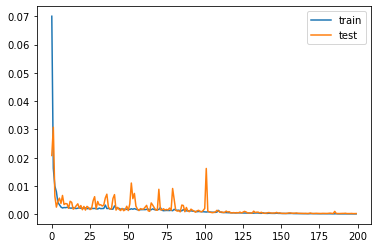

In [39]:
#X_train, X_test, y_train, y_test, input_shape, batch_size=data_preparation_nn(idata, 'slice')

X_train=X_train.reshape((int(X_train.shape[0]),2,500))
X_test=X_test.reshape((int(X_test.shape[0]),2,500))
input_shape=(2,500)
# define encoder
n_inputs=500
visible = layers.Input(shape=(input_shape))
# encoder level 1
e = layers.Dense(n_inputs*2)(visible)
e = layers.BatchNormalization()(e)
e = layers.LeakyReLU()(e)
# encoder level 2
e = layers.Dense(n_inputs)(e)
e = layers.BatchNormalization()(e)
e = layers.LeakyReLU()(e)
# bottleneck
n_bottleneck = 100
bottleneck = layers.Dense(n_bottleneck)(e)
# define decoder, level 1
d = layers.Dense(n_inputs)(bottleneck)
d = layers.BatchNormalization()(d)
d = layers.LeakyReLU()(d)
# decoder level 2
d = layers.Dense(n_inputs*2)(d)
d = layers.BatchNormalization()(d)
d = layers.LeakyReLU()(d)
# output layer
output = layers.Dense(n_inputs, activation='linear')(d)
# define autoencoder model
model = tf.keras.models.Model(inputs=visible, outputs=output)
# compile autoencoder model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# fit the autoencoder model to reconstruct input
history = model.fit(X_train, X_train, epochs=200, batch_size=16, verbose=2, validation_data=(X_test,X_test))
# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
# define an encoder model (without the decoder)
encoder = tf.keras.models.Model(inputs=visible, outputs=bottleneck)
# save the encoder to file
encoder.save('encoder.h5')

In [40]:
#X_train, X_test, y_train, y_test, input_shape, batch_size=data_preparation_nn(idata, 'slice')

# load the model from file
encoder = load_model('encoder.h5', compile=False)
# encode the train data
X_train_encode = encoder.predict(X_train)
# encode the test data
X_test_encode = encoder.predict(X_test)



X_train_encode=X_train_encode.reshape((X_train_encode.shape[0],X_train_encode.shape[2],2))
X_test_encode=X_test_encode.reshape((X_test_encode.shape[0],X_test_encode.shape[2],2))

input_shape_cnn=(n_bottleneck,2)

steps=300
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=100)

model = models.Sequential()
model.add(layers.BatchNormalization(input_shape=input_shape_cnn))
model.add(layers.GaussianNoise(0.1))

for i in range(3):
    model.add(layers.Conv1D(filters=60, kernel_size=(2), padding='valid',activation='relu'))
    model.add(layers.Conv1D(filters=120, kernel_size=(8), padding='valid',activation='tanh'))
    model.add(layers.MaxPooling1D((2)))

model.add(layers.Dense(units=200))

model.add(layers.Dense(units=800))


model.add(layers.Flatten())
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer=optimizers.Adam(learning_rate = 0.0001),
          loss=tf.keras.losses.categorical_crossentropy,
          metrics=['accuracy'])

history=model.fit(X_train_encode, y_train, batch_size=batch_size, epochs=steps, verbose=1, validation_split=0.2,
                 callbacks=[callback])


Epoch 1/300
339/339 [==============================] - 49s 144ms/step - loss: 0.8108 - accuracy: 0.5582 - val_loss: 0.7690 - val_accuracy: 0.5957
Epoch 2/300
339/339 [==============================] - 2s 6ms/step - loss: 0.6937 - accuracy: 0.6221 - val_loss: 0.7735 - val_accuracy: 0.5839
Epoch 3/300
339/339 [==============================] - 2s 6ms/step - loss: 0.6602 - accuracy: 0.6747 - val_loss: 0.7138 - val_accuracy: 0.6099
Epoch 4/300
339/339 [==============================] - 2s 7ms/step - loss: 0.6004 - accuracy: 0.6824 - val_loss: 0.7031 - val_accuracy: 0.6359
Epoch 5/300
339/339 [==============================] - 2s 6ms/step - loss: 0.5615 - accuracy: 0.7008 - val_loss: 0.7263 - val_accuracy: 0.6501
Epoch 6/300
339/339 [==============================] - 2s 7ms/step - loss: 0.5300 - accuracy: 0.7209 - val_loss: 0.7222 - val_accuracy: 0.6241
Epoch 7/300
339/339 [==============================] - 2s 6ms/step - loss: 0.5063 - accuracy: 0.7433 - val_loss: 0.7397 - val_accuracy: 0.6

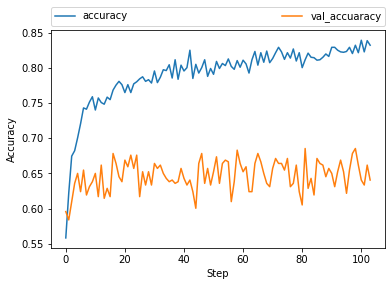

f1_score for each class
[0.93820225 0.56896552 0.59322034]
Global f1_score
0.7003960097567902
Global accuracy
0.7013232514177694


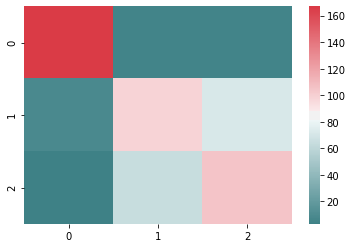

In [41]:
plot_accuracy(history)
test_metrics(model, y_test, X_test_encode)